# <p style = "text-align: center"> <b>  XỬ LÝ ẢNH SỐ VÀ VIDEO SỐ - LAB 02 </b> </p>

### -  Họ tên: Võ Nguyễn Hoàng Kim ###
### -  Mã số sinh viên: 21127090 ###

# <b> Các thư viện cần thiết </b>

In [1]:
import numpy as np
import cv2      
import matplotlib.pyplot as plt

### Cài đặt các hàm cần thiết

In [2]:
# grayImg = cv2.imread("Lenna.jpg", cv2.IMREAD_GRAYSCALE)
grayImg = cv2.imread("Lenna.jpg", cv2.IMREAD_GRAYSCALE)

def plotToCompare(img1, img2, t1 = 'Mine', t2 = 'CV2'):
    plt.figure(figsize=(15, 15))
    plt.subplots_adjust(wspace=1)

    plt.subplot(1, 2, 1)
    plt.title(t1)
    plt.imshow(img1, cmap='gray')

    plt.subplot(1, 2, 2)
    plt.title(t2)
    plt.imshow(img2, cmap='gray')
    
def myConvolution(arr, mask, kSize=3) :
    padding = int((kSize - 1) / 2)
    resArr = np.zeros_like(arr, np.float64)
    for i in range(padding, arr.shape[0] - padding):
        for j in range(padding, arr.shape[1] - padding):
            resArr[i][j] = np.sum(arr[np.clip(i - padding, 0, arr.shape[0]) : np.clip(i + padding + 1, 0, arr.shape[0]) ,
                                      np.clip(j - padding, 0, arr.shape[1]) : np.clip(j + padding + 1, 0, arr.shape[1])]*mask).astype('float64')
    return resArr
            

## <b>1. Gradient Operator </b>

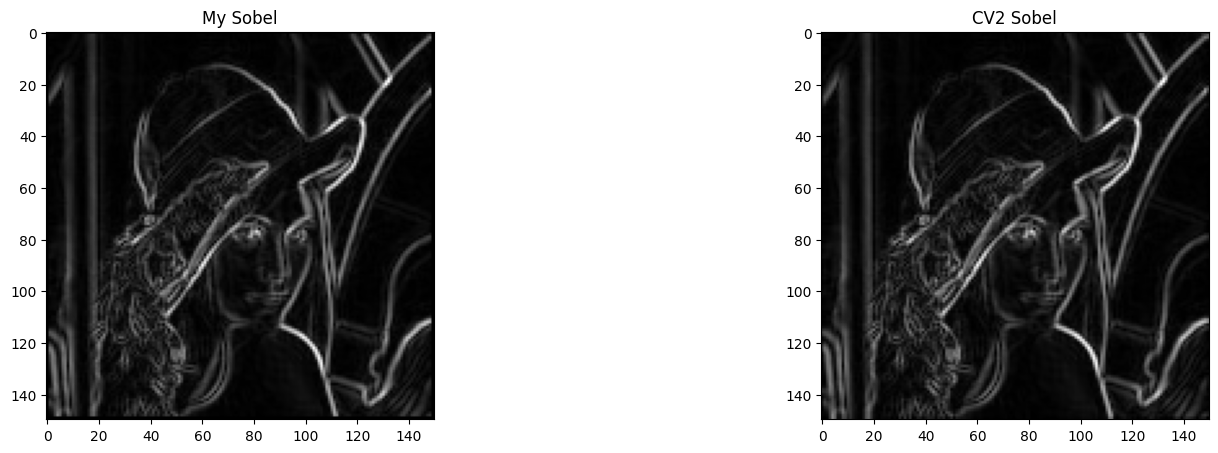

In [3]:
SobelMaskX = np.array([ [1, 0, -1], 
                        [2, 0, -2], 
                        [1, 0, -1]])
SobelMaskY = np.array([ [-1, -2, -1], 
                        [0, 0, 0], 
                        [1, 2, 1]])

# theo chiều ngang : nhân tích chập cho X
def dectecBySobel(img) :            
    # tính Gx bằng đạo hàm theo x (tính tích chập với mask SobelMaskX)
    sobelByX = myConvolution(img ,SobelMaskX)
    
    # tính Gx bằng đạo hàm theo y (tính tích chập với mask SobelMaskY)
    sobelByY = myConvolution(img ,SobelMaskY)
    
    # sử dụng công thức |G| = |Gx| + |Gy| để giảm độ tính toán cho công thức gốc
    magnitude = np.abs(sobelByX) + np.abs(sobelByY)
    
    return magnitude

resImg = dectecBySobel(grayImg)


sobelX = cv2.Sobel(grayImg, cv2.CV_64F, 1, 0, ksize= 3)
sobelY = cv2.Sobel(grayImg, cv2.CV_64F, 0, 1, ksize= 3)
sobel = np.abs(sobelX) + np.abs(sobelY)

plotToCompare(resImg, sobel, t1 = 'My Sobel', t2 = 'CV2 Sobel')


# <b>2. Laplace Operator </b>

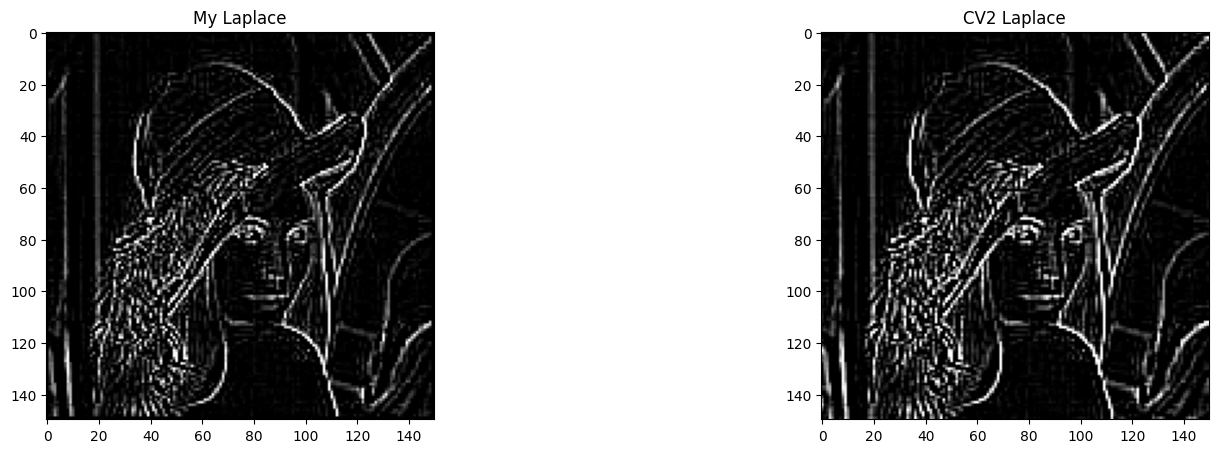

In [4]:
LaplaceMask = np.array([[1, 1, 1], 
                        [1, -8, 1], 
                        [1, 1, 1]])



def dectectByLaplace(img, findZeroCrossing = False) :
    # thực hiện tính tích chập giữa ảnh và bộ lọc Laplace
    laplaceImg = myConvolution(img, LaplaceMask)
    return np.clip(laplaceImg,0, 255).astype('float64')

        

resImg = dectectByLaplace(grayImg, False)

laplacian = cv2.Laplacian(grayImg, -1, ksize=3)


plotToCompare(resImg, laplacian, t1 = 'My Laplace', t2 = 'CV2 Laplace')

# <b>3. Laplace of Gaussian </b>

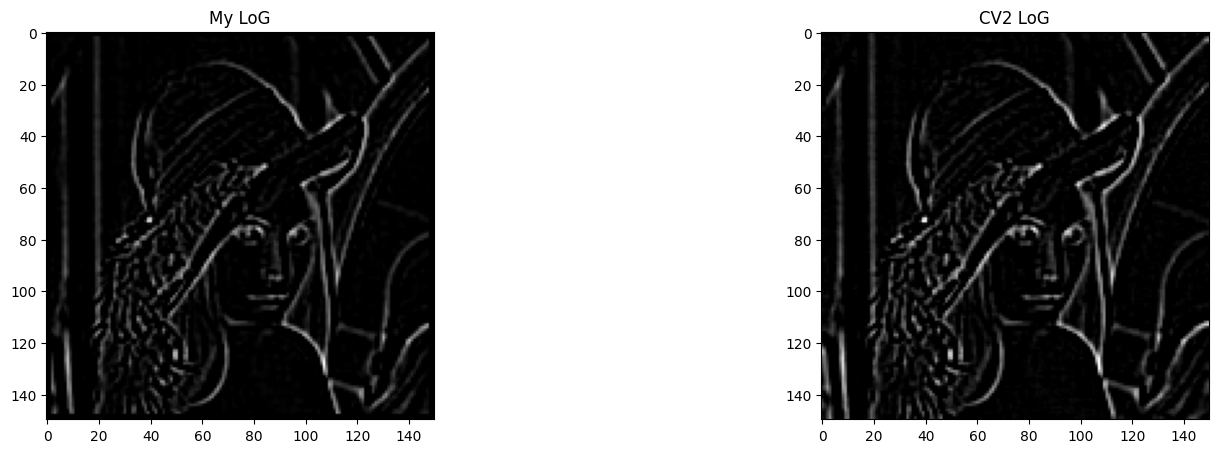

In [5]:
# bộ lọc Gaussian
GaussianKernel = np.array([[1,2,1],
                            [2,4,2],
                            [1,2,1]])/16
# bộ lọc Laplace
LaplaceMask = np.array([[1, 1, 1], 
                        [1, -8, 1], 
                        [1, 1, 1]])

def laplaceOfGaussian(img):
    # làm mịn ảnh bằng bộ lọc Gauss
    gaussImg = myConvolution(grayImg, GaussianKernel)
    # thực hiện phương pháp laplace: nhân tích chập với bộ lọc Laplace
    LoGImg = myConvolution(gaussImg, LaplaceMask)
    return np.clip(LoGImg, 0, 255) 
    
LoGImg = laplaceOfGaussian(grayImg)

blurImg = cv2.GaussianBlur(grayImg, (3,3), 0)
LoG = cv2.Laplacian(blurImg, -1, ksize=3)

plotToCompare(LoGImg, LoG, t1 = 'My LoG', t2 = 'CV2 LoG')

# <b>4. Canny </b>

### Bước 1. Chuẩn bị ảnh cho thuật toán Canny

In [6]:
# các bộ lọc được sử dụng 
SobelMaskX = np.array([ [1, 0, -1], 
                        [2, 0, -2], 
                        [1, 0, -1]])
SobelMaskY = np.array([ [-1, -2, -1], 
                        [ 0,  0,  0], 
                        [ 1,  2,  1]])
GaussianKernel = np.array([ [1,  4,  7,  4, 1],
                            [4, 16, 26, 16, 4],
                            [7, 26, 41, 26, 7],
                            [4, 16, 26, 16, 4],
                            [1,  4,  7,  4, 1]])/273

def preProcess(img):
    # Làm mịn ảnh bằng Gaussian kernel kích thước 3x3
    blurImg = cv2.filter2D(img, cv2.CV_64F, GaussianKernel)
    
    # tính biên độ cạnh và góc
    Gx = cv2.filter2D(blurImg, -1, SobelMaskX)
    Gy = cv2.filter2D(blurImg, -1, SobelMaskY)
    
    edge = np.abs(Gx) + np.abs(Gy)
    angle = np.arctan2(Gy, Gx)
    return edge, angle

gradientImg, theta = preProcess(grayImg)

### Bước 2. Xét các giá trị - thực hiện <b>Non-maximum Suppression </b>

In [7]:
def nonMaximalSuppression(imgGradient, theta):
    
    n,m = imgGradient.shape
    
    # ép góc về [0, 180 độ]
    angleGradient = theta * 180. / np.pi
    angleGradient[angleGradient<0] +=180
    
    resArr = np.zeros((n,m), np.int32)
    
    # thực hiện tìm cực đại cục bộ giữa 2 điểm kề (theo hướng của góc)
    # đồng thời loại các điểm không là cực đại
    for i in range(1, n - 1):
        for j in range(1, m - 1):                
            # sử dụng bộ lọc kích thước 3x3 để lưu các điểm xung quanh
            area = imgGradient[i-1 : i+2, j-1 : j+2]
            
            # 0 độ --> xét 2 điểm thẳng hàng theo trục x
            if (0 <= angleGradient[i,j] < 22.5) or (157.5 <= angleGradient[i,j] <= 180):
                val1 = area[1, 2]
                val2 = area[1, 0]
            # 45 độ --> xét 2 điểm ở đường chéo phải (trên) 
            elif (22.5 <= angleGradient[i,j] < 67.5):
                val1 = area[2, 0]
                val2 = area[0, 2]
            # 90 độ --> xét 2 điểm thẳng hàng theo trục y
            elif (67.5 <= angleGradient[i,j] < 112.5):
                val1 = area[2, 1]
                val2 = area[0, 1]
            # 135 độ --> xét 2 điểm ở đường chéo tráo (trên)
            elif (112.5 <= angleGradient[i,j] < 157.5):
                val1 = area[0, 0]
                val2 = area[2, 2]
            # thực hiện kiểm tra cực đại cục bộ
            if (imgGradient[i,j] > max(val1, val2)):
                resArr[i,j] = imgGradient[i,j]      # giữ lại
            else:
                resArr[i,j] = 0     # loại đi
    return resArr

nonMaxSup = nonMaximalSuppression(gradientImg, theta)

### Bước 3. Xét ngưỡng để phân biệt loại cạnh

In [8]:
def doubleThreshold(nonMaxSupImg, maxVal, minVal):
    # sử dụng threshold từ giá trị biên độ của ảnh tính toán với các hệ số ratio
    standardRadio = 0.15
    
    maxRatio = maxVal*standardRadio/255
    minRatio = minVal*standardRadio/255
    
    maxVal = nonMaxSupImg.max() * maxRatio
    minVal = maxVal* minRatio
    # maxVal = 
    n,m = nonMaxSupImg.shape
    # thực hiện phân loại cạnh mạnh, yếu, không liên quan
    myArr = np.zeros((n,m), np.int32)
    
    # cạnh trên ngưỡng maxVal sẽ là cạnh mạnh, mang giá trị là 255
    myArr[nonMaxSupImg >= maxVal] = 255
    
    # những cạnh nằm trong khoảng từ [minVal, maxVal] sẽ là cạnh yếu, giá trị này tự gán
    # để phân biệt cạnh yếu và không liên quan
    myArr[(nonMaxSupImg <= maxVal) * (nonMaxSupImg >= minVal) ] = 50
    return myArr

# các tham số gratio có thể được truyền hoặc để giá trị mặc định
thresholdImg = doubleThreshold(nonMaxSup, minVal = 100, maxVal = 200)

### Bước 4. Thực hiện nối các cạnh bằng <b>Hysteresis</b> 

In [9]:
def hysteresis(thresholdImg):
    n,m = thresholdImg.shape
    
    for i in range(1, n-1):
        for j in range(1, m-1):
            # xét các cạnh là yếu và vùng lân cận của nó
            if(thresholdImg[i,j] == 50):
                # sử dụng lân cận 8
                area = thresholdImg[i-1:i+2, j-1: j+2]
                # nếu một trong các lân cận của nó là cạnh mạnh thì nó sẽ được chuyển thành mạnh
                if(area.any() == 255):
                    thresholdImg[i,j] = 255
                # ngược lại, sẽ chuyển về cạnh không liên quan
                else: 
                    thresholdImg[i,j] = 0
    return thresholdImg

finalImg = hysteresis(thresholdImg)

### 5. So sánh kết quả

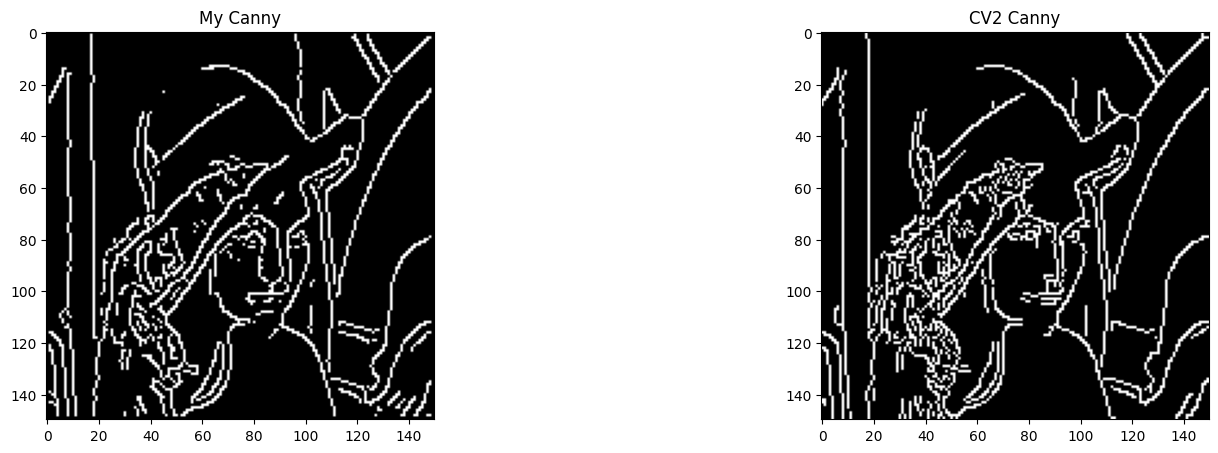

In [10]:

# sử dụng threshold dựa trên giá trị biên độ 
canny = cv2.Canny(grayImg, threshold1 = 100, threshold2 = 200)
plotToCompare(finalImg, canny, t1 = 'My Canny', t2 = 'CV2 Canny')